In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Emotion item data](#emotion)
    - Reformatting
    - Exploring
- [fMRI data](#fmri)
    - Reformatting
    - Exploring

<a class="anchor" id="emotion"></a>
### Emotion item data

In [10]:
emo_path = "./data/emo/"

We simplify the datasets so to make it easier in the future to load. Be careful that the formats for any of our processed emotion csv would be the following way.

Reformatting

In [11]:
# we find the labels matching the index to know which item we are accessing
df     = pd.read_csv(emo_path + '/W_labels.csv', sep='\t')
labels = list(df.columns) + list(df.iloc[:,0])
labels = {idx:emotion for idx, emotion in enumerate(labels)}

In [12]:
# we keep a dictionary with each film and their respective scores for each item in a double array
record = {'filename': [], 'item': [], 'score': []}
for filename in tqdm(os.listdir(emo_path)):
    if 'labels' in filename: continue
    df           = pd.read_csv(emo_path + '/' + filename, sep='\t')
    double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
    nbt, nbitem  = double_array.shape
    
    for item_idx in range(nbitem):
        record['score'] += list(double_array[:,item_idx])
        record['item'] += ([labels[item_idx]] * nbt)

    record['filename'] += ([filename] * nbt * nbitem)

emo_df = pd.DataFrame.from_dict(record)

# #Uncomment to save the record to csv
# emo_df.to_csv('./data/emotion_compile.csv', index=False)

100%|██████████| 15/15 [00:00<00:00, 74.17it/s]


Exploring

From the following plot we see in each videos whether the item is present

In [13]:
stats1    = emo_df.groupby(['filename', 'item']).mean()
stats1inv = emo_df.groupby(['item', 'filename']).mean()
stats2inv = emo_df.groupby(['item', 'filename']).std()

Text(0, 0.5, 'mean score of Sad')

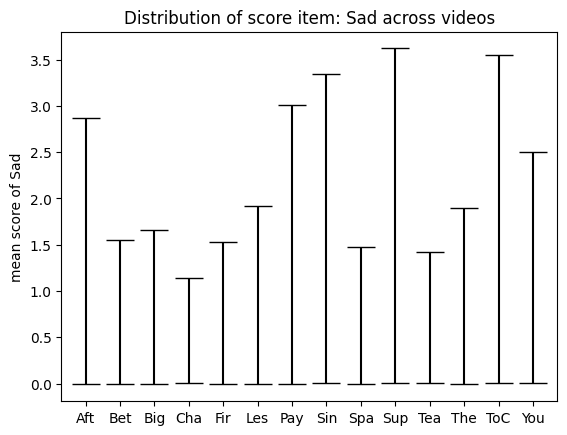

In [14]:
item = 'Sad'
nb_vid = stats1inv.loc[item].shape[0]
fig, ax = plt.subplots()

# create bar plot
movie_labels = list(stats1inv.loc[item].index)
movie_labels = [m[2:5] for m in movie_labels]

means = np.array(stats1inv.loc[item]['score'])
stds  = np.array(stats2inv.loc[item]['score'])
plt.bar(movie_labels, means, 
        yerr= [np.zeros_like(stds), stds], capsize=10,
        color ='maroon', width = 0.1)
plt.title("Distribution of score item: {} across videos".format(item))
plt.ylabel('mean score of {}'.format(item))

Let's as well visualize the timeseries for few items in a movie

In [15]:
emo_df.item.unique()

array(['Support', 'Stop', 'Care', 'Sad', 'Predictable', 'Lips', 'Throat',
       'Move', 'Frown', 'Warm', 'Guilt', 'PleasantSelf', 'Tackle',
       'PleasantOther', 'Controlled', 'Standards', 'Disgust', 'Agent',
       'AtEase', 'Oppose', 'Tears', 'Anxiety', 'IntenseEmotion',
       'Attention', 'Stomach', 'Good', 'Alert', 'Happiness', 'Calm',
       'Anger', 'Eyebrows', 'Repeat', 'Muscle', 'SocialNorms', 'Smile',
       'Surprise', 'Bad', 'Suddenly', 'GoalsOther', 'WarmHeartedness',
       'Love', 'Heartrate', 'Satisfaction', 'Fear', 'Contempt', 'Command',
       'Urgency', 'Shame', 'Strong', 'Undo'], dtype=object)

Text(0.5, 1.0, 'Scores over time for W_TearsOfSteel13.csv')

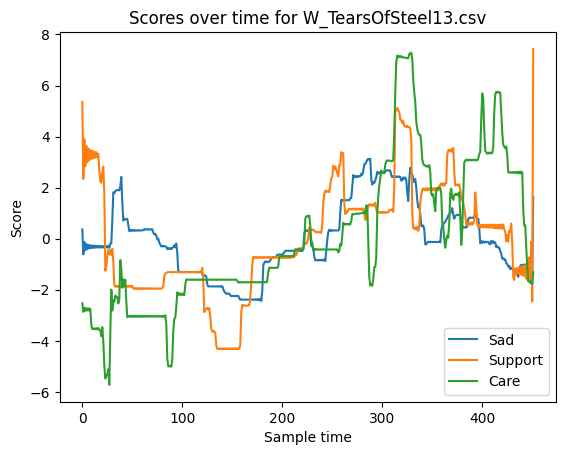

In [16]:
# NOTE: that the temporal coherence was kept when we reformatted the files
moviename = 'W_TearsOfSteel13.csv'
emotions  = ['Sad', 'Support', 'Care']

cur_df1 = emo_df[(emo_df['filename'] == moviename) & 
        (emo_df['item'] == emotions[0])]
cur_df2 = emo_df[(emo_df['filename'] == moviename) & 
        (emo_df['item'] == emotions[1])]
cur_df3 = emo_df[(emo_df['filename'] == moviename) & 
        (emo_df['item'] == emotions[2])]        

plt.plot(np.arange(len(cur_df1)), cur_df1['score'], label=emotions[0])
plt.plot(np.arange(len(cur_df2)), cur_df2['score'], label=emotions[1])
plt.plot(np.arange(len(cur_df3)), cur_df3['score'], label=emotions[2])
plt.legend()
plt.xlabel('Sample time')
plt.ylabel('Score')
plt.title('Scores over time for {}'.format(moviename))

<a class="anchor" id="fmri"></a>
### fMRI data

In [2]:
mri_path = "./data/fMRI_400/"

Reformatting

In [3]:
labels = pd.read_csv('./data/7N_networks_centroids.csv')

In [8]:
# we keep a dictionary with each film and their respective scores for each item in a double array
record = {'filename': [], 'vindex': [],'full_region': [], 
            'partial_region': [],'score': [], 'is_movie': []}
flag   = 0 
for filename in tqdm(os.listdir(mri_path)):
    flag = 'Sintel' in filename
    df           = pd.read_csv(mri_path + '/' + filename)
    double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
    nbt, nbvoxel = double_array.shape
    
    for voxel_idx in range(nbvoxel):
        record['score'] += list(double_array[:,voxel_idx])
        record['vindex'] += [voxel_idx] * nbt
        
        region_name  = labels[labels['ROI Label'] == voxel_idx + 1]['ROI Name'].item()
        # partial_name = '_'.join(region_name.split('_')[1:-1])
        partial_name = region_name.split('_')[2]
        record['full_region']    += ([region_name] * nbt)
        record['partial_region'] += ([partial_name] * nbt)


    record['filename'] += ([filename] * nbt * nbvoxel)
    record['is_movie'] += ([flag] * nbt * nbvoxel)

mri_df = pd.DataFrame.from_dict(record)

# #Uncomment to save the record to csv
# mri_df.to_csv('./data/fmri_compile.csv', index=False)

100%|██████████| 60/60 [00:08<00:00,  6.96it/s]


Exploring

Plot a few timeseries for some arbitrary voxels

Text(0, 0.5, 'Bold')

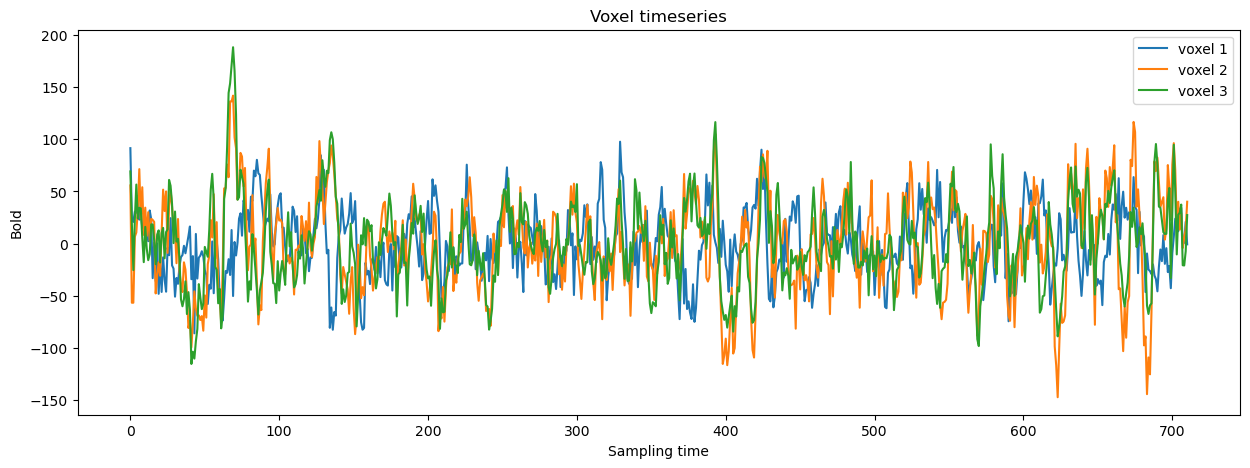

In [80]:
filename = 'TC_400_sub-S09_ses-4_Sintel.csv'
tmp      = df_to_timeseries(mri_df, filename)

plt.figure(figsize=(15,5))
plt.plot(tmp[:,0], label='voxel 1')
plt.plot(tmp[:,10], label='voxel 2')
plt.plot(tmp[:,20], label='voxel 3')
plt.legend()
plt.title('Voxel timeseries')
plt.xlabel('Sampling time')
plt.ylabel('Bold')